In [8]:
import os
import numpy as np
import librosa
import glob
from sklearn import svm, tree, ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import kagglehub  # For downloading datasets via Kaggle API
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [9]:

# Step 1: Download Dataset Using Kaggle API
def download_dataset():
    """Download the RAVDESS dataset using Kaggle API."""
    path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
    print("Path to dataset files:", path)
    return path

In [10]:
# Step 2: Dataset Preparation with Error Handling
def load_dataset(dataset_path):
    """Load RAVDESS dataset with proper error handling."""
    features = []
    labels = []
    emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy',
        '04': 'sad', '05': 'angry', '06': 'fearful',
        '07': 'disgust', '08': 'surprised'
    }

    print(f"Processing files in: {dataset_path}")

    # Get all audio files with proper path handling
    audio_files = glob.glob(os.path.join(dataset_path, "**/*.wav"), recursive=True)
    print(f"Found {len(audio_files)} audio files")

    skipped_files = 0
    for file_path in audio_files:
        try:
            # Extract emotion from filename (RAVDESS naming convention)
            filename = os.path.basename(file_path)
            parts = filename.split('-')
            emotion_code = parts[2]
            emotion = emotion_map[emotion_code]

            # Load and preprocess audio
            audio, sr = librosa.load(file_path, sr=22050, duration=3)  # Limit to 3s for consistency
            audio, _ = librosa.effects.trim(audio, top_db=20)  # Remove silence

            # Feature extraction (MFCC, Chroma, Mel)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
            chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
            mel = librosa.feature.melspectrogram(y=audio, sr=sr)

            # Aggregate features
            features.append(np.concatenate([
                np.mean(mfcc.T, axis=0),
                np.mean(chroma.T, axis=0),
                np.mean(mel.T, axis=0)
            ]))
            labels.append(emotion)

        except Exception as e:
            skipped_files += 1
            print(f"Skipped {filename}: {str(e)}")

    print(f"\nSuccessfully processed: {len(features)} files")
    print(f"Skipped files: {skipped_files}")
    return np.array(features), np.array(labels)

In [11]:
# Step 3: Model Training with Hyperparameter Tuning
def train_models(X_train, y_train):
    """Train models with optimal hyperparameters."""
    models = {
        'SVM': GridSearchCV(
            svm.SVC(),
            {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
            cv=3
        ),
        'Decision Tree': GridSearchCV(
            tree.DecisionTreeClassifier(),
            {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]},
            cv=3
        ),
        'Random Forest': GridSearchCV(
            ensemble.RandomForestClassifier(),
            {'n_estimators': [50, 100], 'max_depth': [None, 10]},
            cv=3
        )
    }

    print("\nTraining Models:")
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        print(f"Best {name} params: {model.best_params_}")

    return models

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
Processing files in: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
Found 2880 audio files

Successfully processed: 2880 files
Skipped files: 0

Model Evaluation:

SVM Performance:
              precision    recall  f1-score   support

       angry       0.94      0.87      0.90        76
        calm       0.87      0.94      0.90        77
     disgust       0.85      0.91      0.88        77
     fearful       0.92      0.94      0.93        77
       happy       0.91      0.92      0.92        77
     neutral       0.76      0.82      0.78        38
         sad       0.90      0.83      0.86        77
   surprised       0.93      0.88      0.91        77

    accuracy                           0.89       576
   macro avg       0.89      0.89      0.89       576
weighted avg       0.89      0.89      0.89       576



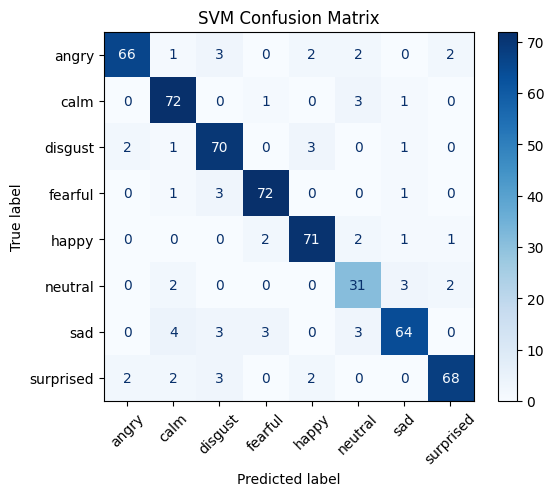


Decision Tree Performance:
              precision    recall  f1-score   support

       angry       0.83      0.92      0.88        76
        calm       0.95      0.90      0.92        77
     disgust       0.94      0.87      0.91        77
     fearful       0.84      0.84      0.84        77
       happy       0.89      0.82      0.85        77
     neutral       0.83      1.00      0.90        38
         sad       0.90      0.92      0.91        77
   surprised       0.84      0.82      0.83        77

    accuracy                           0.88       576
   macro avg       0.88      0.89      0.88       576
weighted avg       0.88      0.88      0.88       576



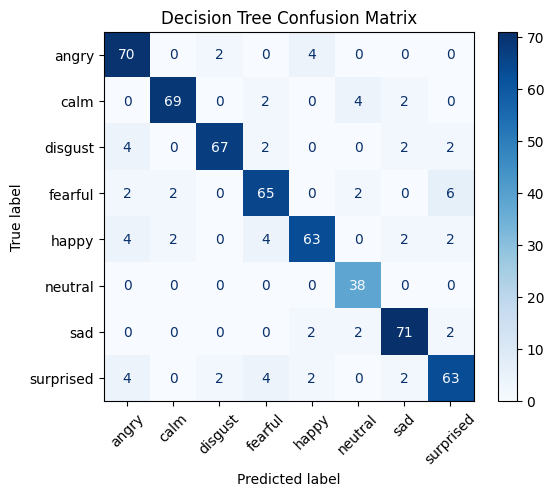


Random Forest Performance:
              precision    recall  f1-score   support

       angry       0.88      0.95      0.91        76
        calm       0.91      1.00      0.95        77
     disgust       0.87      0.90      0.88        77
     fearful       0.87      0.87      0.87        77
       happy       0.97      0.90      0.93        77
     neutral       1.00      0.95      0.97        38
         sad       0.92      0.95      0.94        77
   surprised       0.97      0.84      0.90        77

    accuracy                           0.92       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.92      0.92      0.92       576



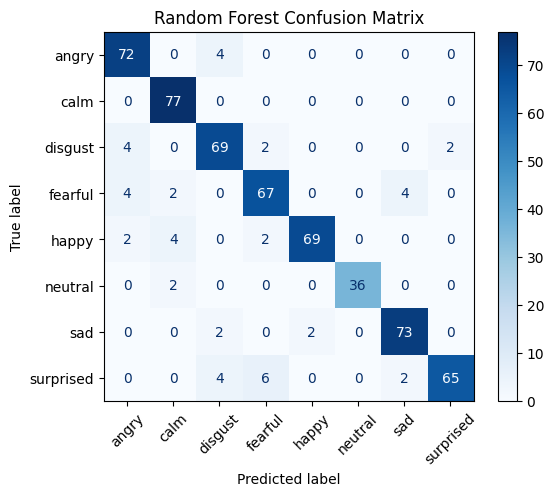


=== Model Performance Comparison ===
| Model         |   Accuracy |   Precision |   Recall |   F1-Score |
|:--------------|-----------:|------------:|---------:|-----------:|
| SVM           |      0.892 |       0.894 |    0.892 |      0.893 |
| Decision Tree |      0.878 |       0.881 |    0.878 |      0.878 |
| Random Forest |      0.917 |       0.919 |    0.917 |      0.917 |


In [12]:



# Main Execution
if __name__ == "__main__":
    # Step 1: Download dataset using Kaggle API
    dataset_path = download_dataset()

    # Step 2: Load dataset and preprocess data
    X, y = load_dataset(dataset_path)

    if len(X) == 0 or len(y) == 0:
        raise ValueError("No data loaded! Check dataset path and file structure.")

    X = np.nan_to_num(X)  # Handle NaN values

    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)




    print("\nModel Evaluation:")
    results = []

    for name, model in models.items():
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store results for comparison
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

        # Print individual report
        print(f"\n{name} Performance:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

        # Confusion matrix plot
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred,
            display_labels=le.classes_,
            cmap='Blues',
            xticks_rotation=45
        )
        plt.title(f'{name} Confusion Matrix')
        plt.show()

    # Create and display comparison table
    results_df = pd.DataFrame(results)
    print("\n=== Model Performance Comparison ===")
    print(results_df.round(3).to_markdown(index=False))





